# Оценка объемов запасов нефти  добывающей компании «ГлавРосГосНефть»

    Заказчик работы добывающая компания «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. 
    Будем выполнять следующие шаги для выбора локации добычи нефти:
1. В избранном регионе соберем характеристики для скважин: качество нефти и объём её запасов;
2. Построим модель для предсказания объёма запасов в новых скважинах;
3. Выбирем скважины с самыми высокими оценками значений;
4. Определим регион с максимальной суммарной прибылью отобранных скважин.
    
    Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. 

## Шаг 1. Загрузите и подготовьте данные.

**Загрузка и предобработка данных**

In [1]:
!pip install phik==0.10.0 -q

In [2]:
!pip install --upgrade scikit-learn -q

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import  StandardScaler
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from math import sqrt
import plotly.express as px
from scipy.stats import binom, poisson
from math import factorial
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler
)

from sklearn.impute import SimpleImputer
# from optuna import distributions
import phik

from sklearn.metrics import make_scorer
from sklearn.pipeline import(
    Pipeline, # Pipeline с ручным вводом названий шагов.
    make_pipeline # Pipeline с автоматическим названием шагов.
)

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams ['figure.figsize'] = [10, 4]

In [5]:
try:
    data_0 = pd.read_csv('C:/Users/almuc/Downloads/geo_data_0.csv', decimal = ',')
    data_1 = pd.read_csv('C:/Users/almuc/Downloads/geo_data_1.csv', decimal = ',')
    data_2 = pd.read_csv('C:/Users/almuc/Downloads/geo_data_2.csv', decimal = ',')
except:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv', decimal = ',')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv', decimal = ',')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv', decimal = ',')

*Нулевой регион*

In [6]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.7057449842080644,-0.4978225001976334,1.22116994843607,105.28006184349583
1,2acmU,1.3347112926051892,-0.3401642528583136,4.3650803324282,73.03775026515737
2,409Wp,1.0227322634721168,0.15199044457022945,1.4199262386740652,85.26564713099945
3,iJLyR,-0.03217162450743976,0.13903270818447744,2.9785659663204838,168.62077555509563
4,Xdl7t,1.988431059439699,0.15541267777667178,4.751769119262962,154.03664673738086


In [7]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       100000 non-null  object
 1   f0       100000 non-null  object
 2   f1       100000 non-null  object
 3   f2       100000 non-null  object
 4   product  100000 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB


В таблице 100000 строк и 5 столбцов. Пропусков нет.

In [8]:
data_0.dtypes

id         object
f0         object
f1         object
f2         object
product    object
dtype: object

Проверим на уникальность значений столбца с объемом запасов нефти.

In [9]:
data_0['product'].unique()

array(['105.28006184349583', '73.03775026515737', '85.26564713099945',
       ..., '64.37544258845939', '74.04076435494164',
       '149.63324560844958'], dtype=object)

Выглядит нормально.

Как я понимаю в таблице указаны долгота, широта и глубина, а также объем запасов в барелях. Данные закодированы как тип object, дамю нужно переделать в float32.

In [10]:
data_0['f0'] = data_0['f0'].astype('float32')

In [11]:
data_0['f1'] = data_0['f1'].astype('float32')

In [12]:
data_0['f2'] = data_0['f2'].astype('float32')

In [13]:
data_0['product'] = data_0['product'].astype('float32')

Переведем столбец id в индекс.

In [14]:
data_0 = data_0.set_index('id')

In [15]:
data_0.dtypes

f0         float32
f1         float32
f2         float32
product    float32
dtype: object

Теперь данные в норме.

Посчитаем наличие явных дубликатов

In [16]:
print('Количество явных дубликатов в нулевом регионе', data_0.duplicated().sum())

Количество явных дубликатов в нулевом регионе 0


Явные дубликаты не обнаружены.

*Первый регион*

In [17]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.00134818249185,-8.275999947188001,-0.005876013693320655,3.179102583207246
1,62mP7,14.272087811011147,-3.47508321506002,0.9991827365665829,26.95326103153969
2,vyE1P,6.263187352448809,-5.948385788285711,5.001160160764809,134.76630515769844
3,KcrkZ,-13.081196289023516,-11.506056864519605,4.999414898074921,137.94540774090564
4,AHL4O,12.702194885533585,-8.147433374146587,5.00436255224226,134.76630515769844


In [18]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       100000 non-null  object
 1   f0       100000 non-null  object
 2   f1       100000 non-null  object
 3   f2       100000 non-null  object
 4   product  100000 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB


В таблице 100000 строк и 5 столбцов. Пропусков нет.

In [19]:
data_1.dtypes

id         object
f0         object
f1         object
f2         object
product    object
dtype: object

Проверим на уникальность значений столбца с объемом запасов нефти. 

In [20]:
data_1['product'].unique()

array(['3.179102583207246', '26.95326103153969', '134.76630515769844',
       '137.94540774090564', '84.03888567782631', '110.992146709366',
       '53.90652206307938', '0.0', '107.81304412615876',
       '57.08562464628662', '30.132363614746943', '80.85978309461906'],
      dtype=object)

Очень страно, в 100 тыс скважин всего 12 значений. Такое ощущение, что либо в данных ошибка, либо бурили в одном месте. Но так как это синтетические данные оставим как есть.

Переведем данные также в float32

In [21]:
data_1['f0'] = data_1['f0'].astype('float32')

In [22]:
data_1['f1'] = data_1['f1'].astype('float32')

In [23]:
data_1['f2'] = data_1['f2'].astype('float32')

In [24]:
data_1['product'] = data_1['product'].astype('float32')

А также столбец id переведем в индекс.

In [25]:
data_1 = data_1.set_index('id')

In [26]:
data_1.dtypes

f0         float32
f1         float32
f2         float32
product    float32
dtype: object

Данные в норме.

Проверим наличие явных дубликатов

In [27]:
print('Количество явных дубликатов в первом регионе', data_1.duplicated().sum())

Количество явных дубликатов в первом регионе 0


Дубликаты не обнаружены.

*Второй регион*

In [28]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.1469870984179529,0.9633279217162892,-0.8289649221710994,27.758673230730036
1,WJtFt,0.2627779016539684,0.2698389572803021,-2.530186515492004,56.06969663239464
2,ovLUW,0.19458728165865746,0.2890350017576741,-5.586432770903118,62.87191004763475
3,q6cA6,2.2360596126935817,-0.5537598999099264,0.930037615920042,114.57284166750858
4,WPMUX,-0.5159928644136754,1.7162655596688288,5.899011469346728,149.60074591275887


In [29]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       100000 non-null  object
 1   f0       100000 non-null  object
 2   f1       100000 non-null  object
 3   f2       100000 non-null  object
 4   product  100000 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB


В таблице 100000 строк и 5 столбцов. Пропусков нет.

In [30]:
data_2.dtypes

id         object
f0         object
f1         object
f2         object
product    object
dtype: object

Аналогично как с другими данными.

Проверим на уникальность значений столбца с объемом запасов нефти.

In [31]:
data_2['product'].unique()

array(['27.758673230730036', '56.06969663239464', '62.87191004763475',
       ..., '157.08007974797255', '51.79525299383931',
       '102.77576748913316'], dtype=object)

Здесь тоже все выглядит нормально.

In [32]:
data_2['f0'] = data_2['f0'].astype('float32')

In [33]:
data_2['f1'] = data_2['f1'].astype('float32')

In [34]:
data_2['f2'] = data_2['f2'].astype('float32')

In [35]:
data_2['product'] = data_2['product'].astype('float32')

И переведем столбец id в индекс.

In [36]:
data_2 = data_2.set_index('id')

In [37]:
data_2.dtypes

f0         float32
f1         float32
f2         float32
product    float32
dtype: object

Данные в норме.

Проверим наличие явных дуликатов.

In [38]:
print('Количество явных дубликатов во втором регионе', data_2.duplicated().sum())

Количество явных дубликатов во втором регионе 0


Дубликаты не обнаружены.

По итогам предобработки данных могу сделать следующие выводы:
1. Пропуски в таблицах не обнаружены. 
2. Заменен тип данных во всех столбцах кроме id на формат float32.
3. Явные дубликаты в данных не выявлены.

**Исследовательский анализ данных**

*Нулевой регион*

In [39]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871825,0.504431,3.248227,44.288460
min,-1.408605,-0.848219,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564087
max,2.362331,1.343769,16.003790,185.364349


В данных есть места где нет нефти посмотрим на них.

In [40]:
zero_0 = data_0[data_0['product'] == 0]
zero_0

,f0,f1,f2,product
id,,,,
zCM5W,-0.702064,0.375992,0.236572,0.0


Хоть это и одна строка, но учитывать эти данные нужно, т.к. это показывает, что в этом месте лучше не бурить.

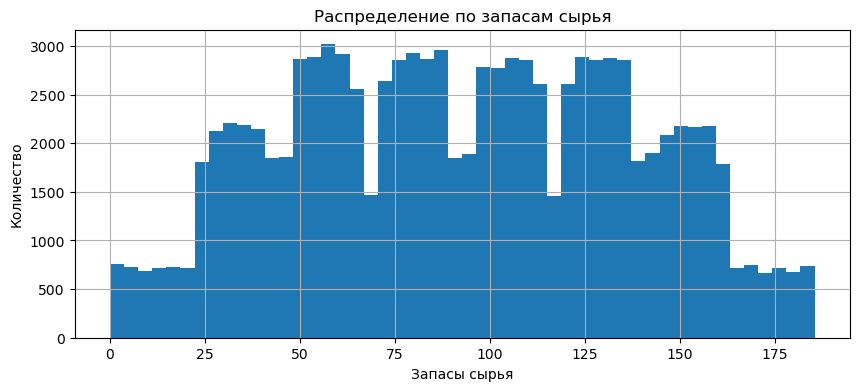

In [41]:
data_0['product'].hist(bins=50)
plt.title("Распределение по запасам сырья")
plt.xlabel('Запасы сырья')
plt.ylabel('Количество')
plt.show()

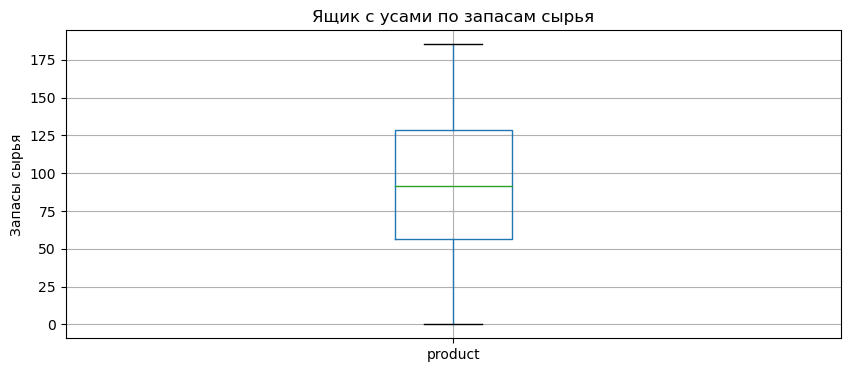

In [42]:
data_0.boxplot('product')
plt.title("Ящик с усами по запасам сырья")
plt.ylabel('Запасы сырья')
plt.show()

В нулевом регионе большинство скважин имеют запас сырья в пределах от 56 до 92 тыс. барелей.

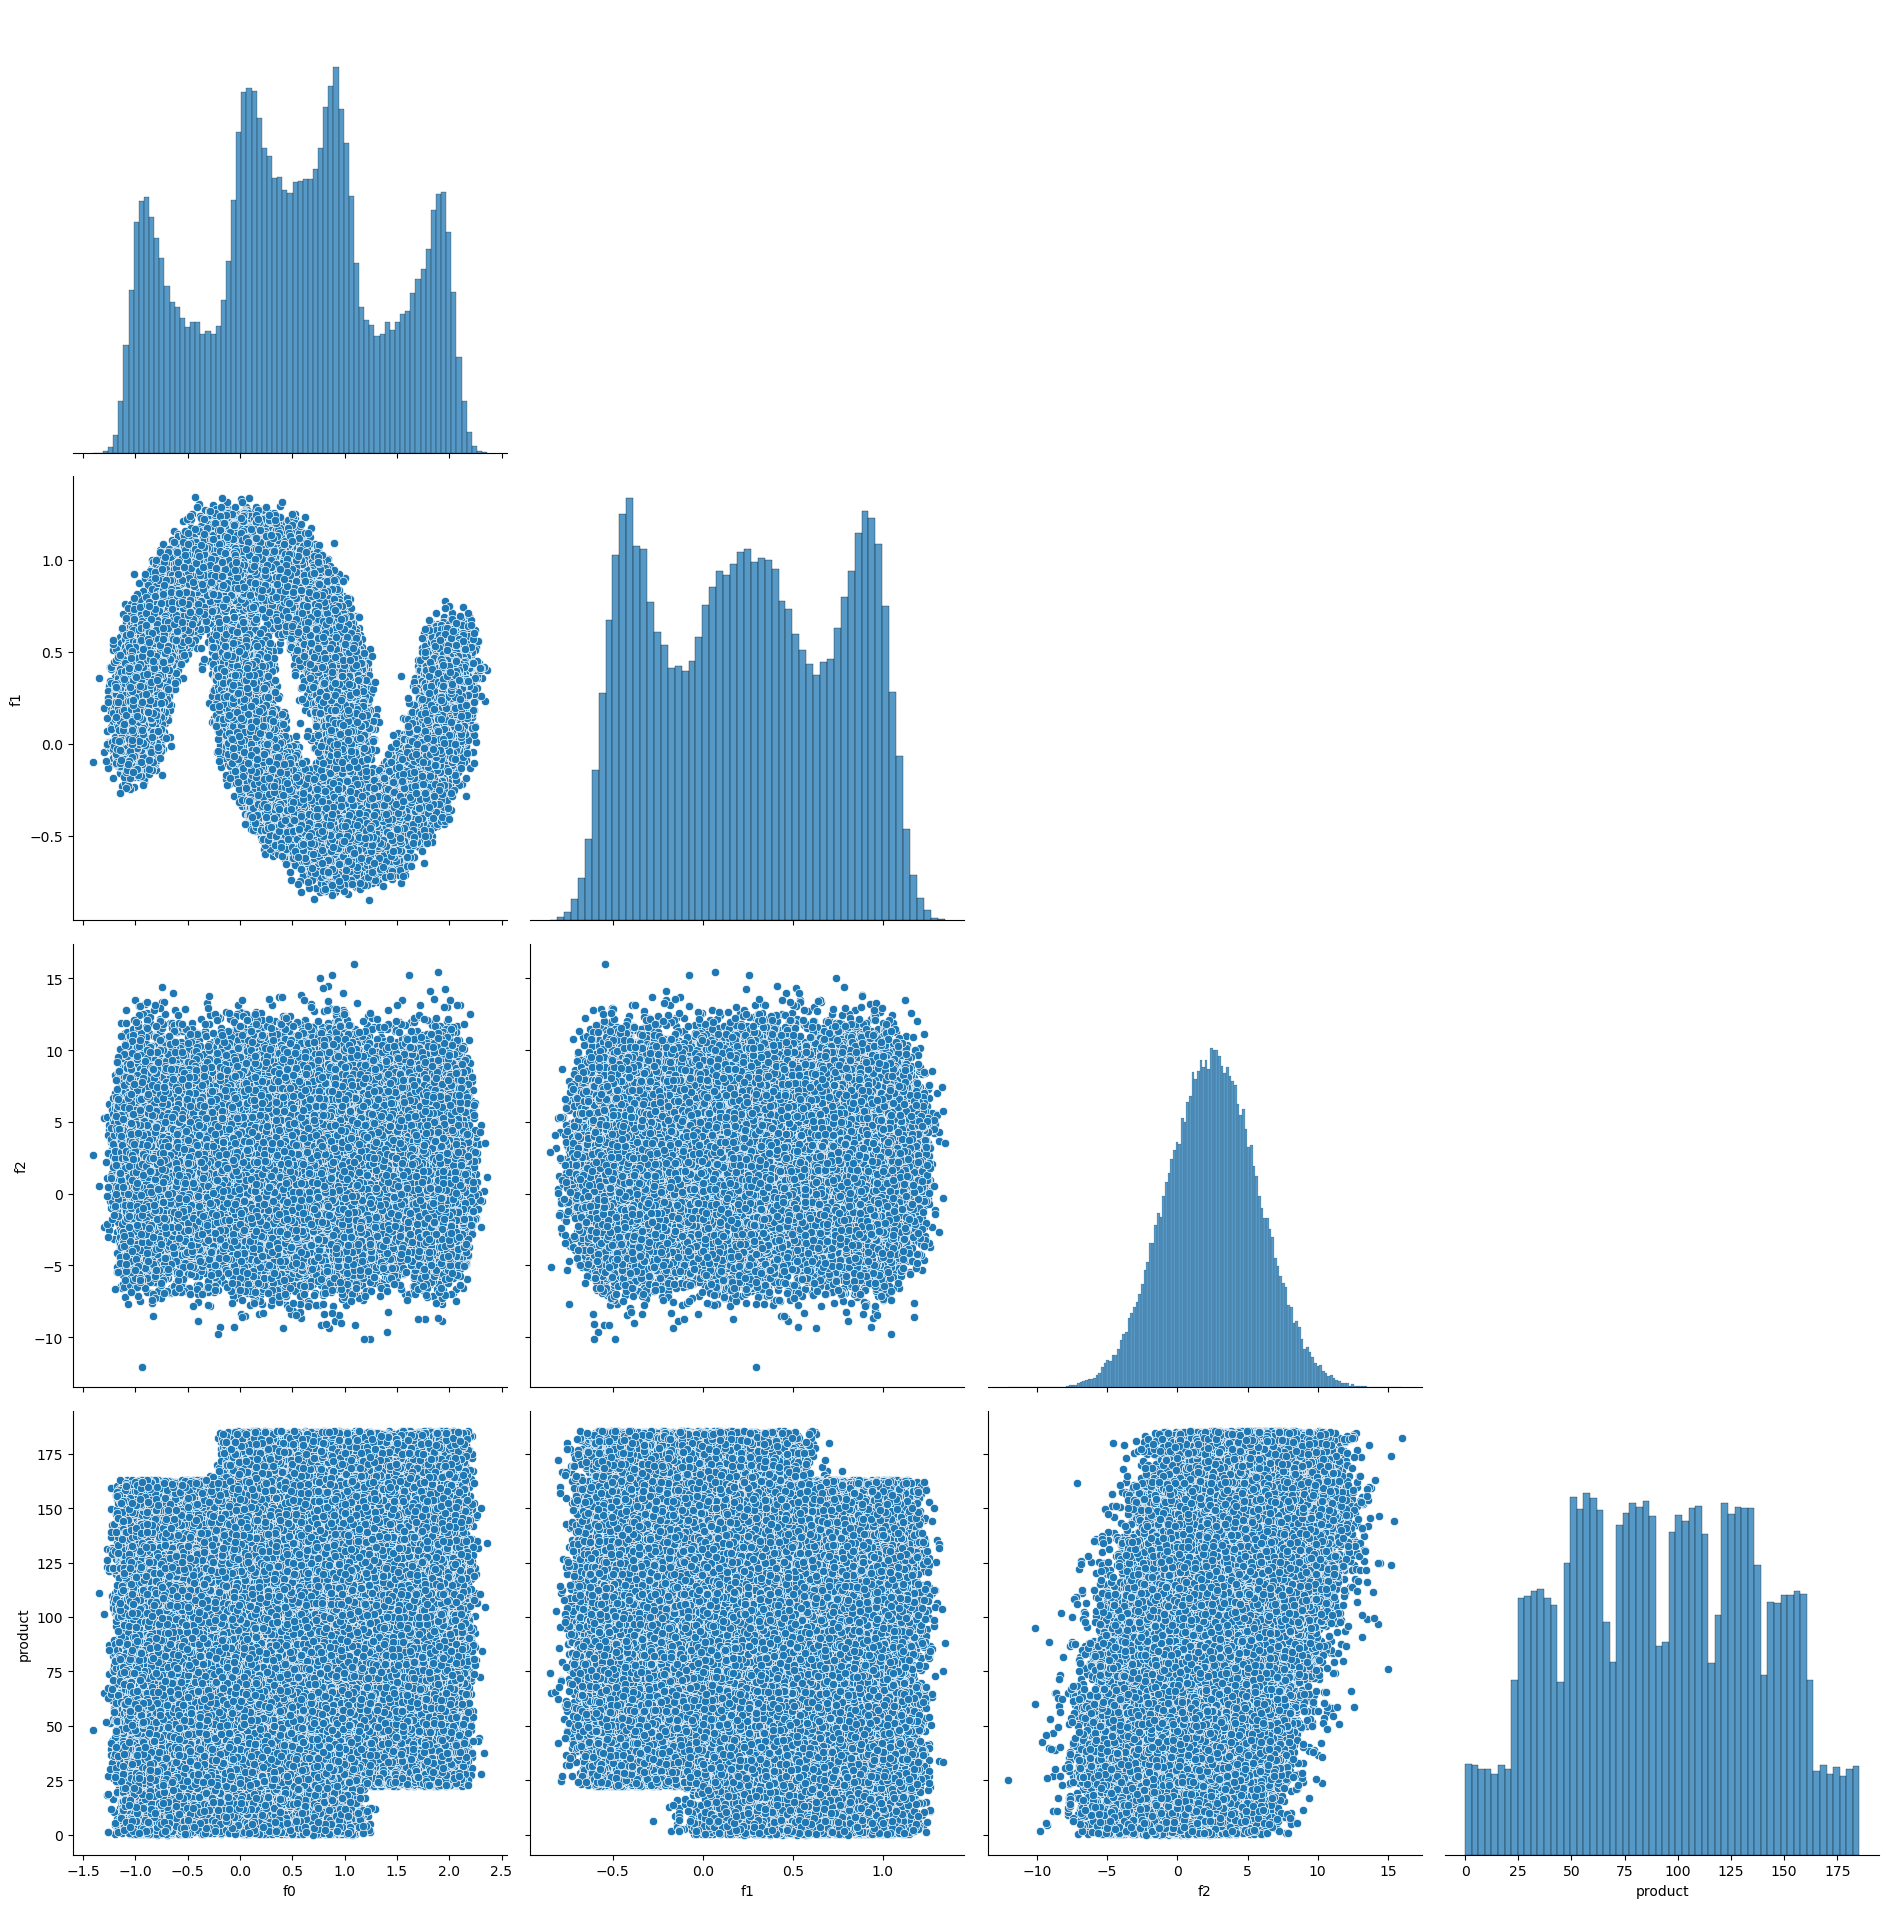

In [43]:
g = sns.pairplot(data_0, corner=True)
g.fig.set_size_inches(20, 20)

In [44]:
cols_numeric = ['f0', 'f1', 'f2', 'product']
data_0.phik_matrix(interval_cols=cols_numeric)

,f0,f1,f2,product
f0,1.000000,0.762170,0.000000,0.215525
f1,0.762170,1.000000,0.000000,0.253544
f2,0.000000,0.000000,1.000000,0.475901
product,0.215525,0.253544,0.475901,1.000000


Сильной линейной зависимости не выявлено. Данные оставляем как есть.

*Первый регион*

In [45]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.824997
std,8.965897,5.119843,1.703575,45.942646
min,-31.609575,-26.358599,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953260
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621016,-1.332816,3.999904,107.813042
max,29.421755,18.734062,5.019721,137.945404


In [46]:
zero_1 = data_1[data_1['product'] == 0]
zero_1

,f0,f1,f2,product
id,,,,
OXyvW,16.320755,-0.562946,-0.001783,0.0
igmai,6.695604,-0.749449,-0.007630,0.0
Qjy5w,21.418478,-5.134490,-0.002836,0.0
G6WCj,6.822701,3.104979,-0.000723,0.0
MzQhL,6.750150,-11.893513,-0.001601,0.0
...,...,...,...,...
YrRU8,5.085749,-3.980305,0.005063,0.0
Jbnur,8.277804,-9.178819,0.003275,0.0
aV1cJ,13.343983,-1.290200,0.005980,0.0


Первый регион не очень богат на нефть, в 8235 скважинах ее вообще не было.

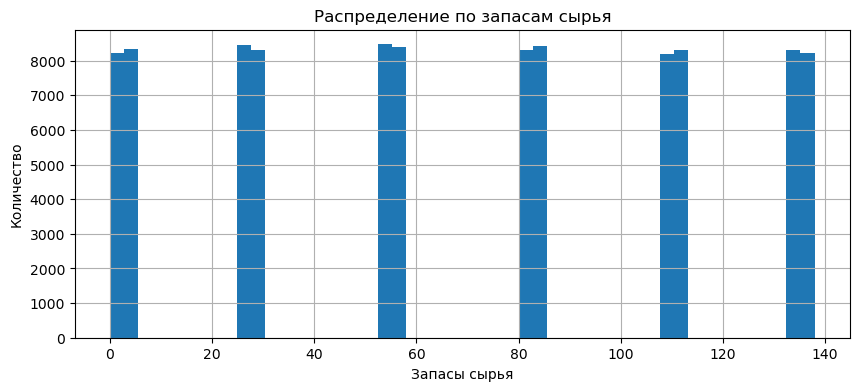

In [47]:
data_1['product'].hist(bins=50)
plt.title("Распределение по запасам сырья")
plt.xlabel('Запасы сырья')
plt.ylabel('Количество')
plt.show()

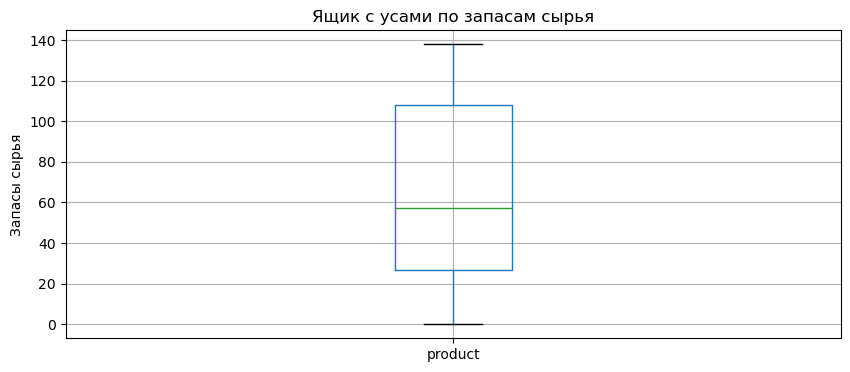

In [48]:
data_1.boxplot('product')
plt.title("Ящик с усами по запасам сырья")
plt.ylabel('Запасы сырья')
plt.show()

В первом регионе распределение очень интересно, разделилось примерно на 6 одинаковых частей. Запасы большинстав скважин колеблется от 26 до 107 тыс. барелей.

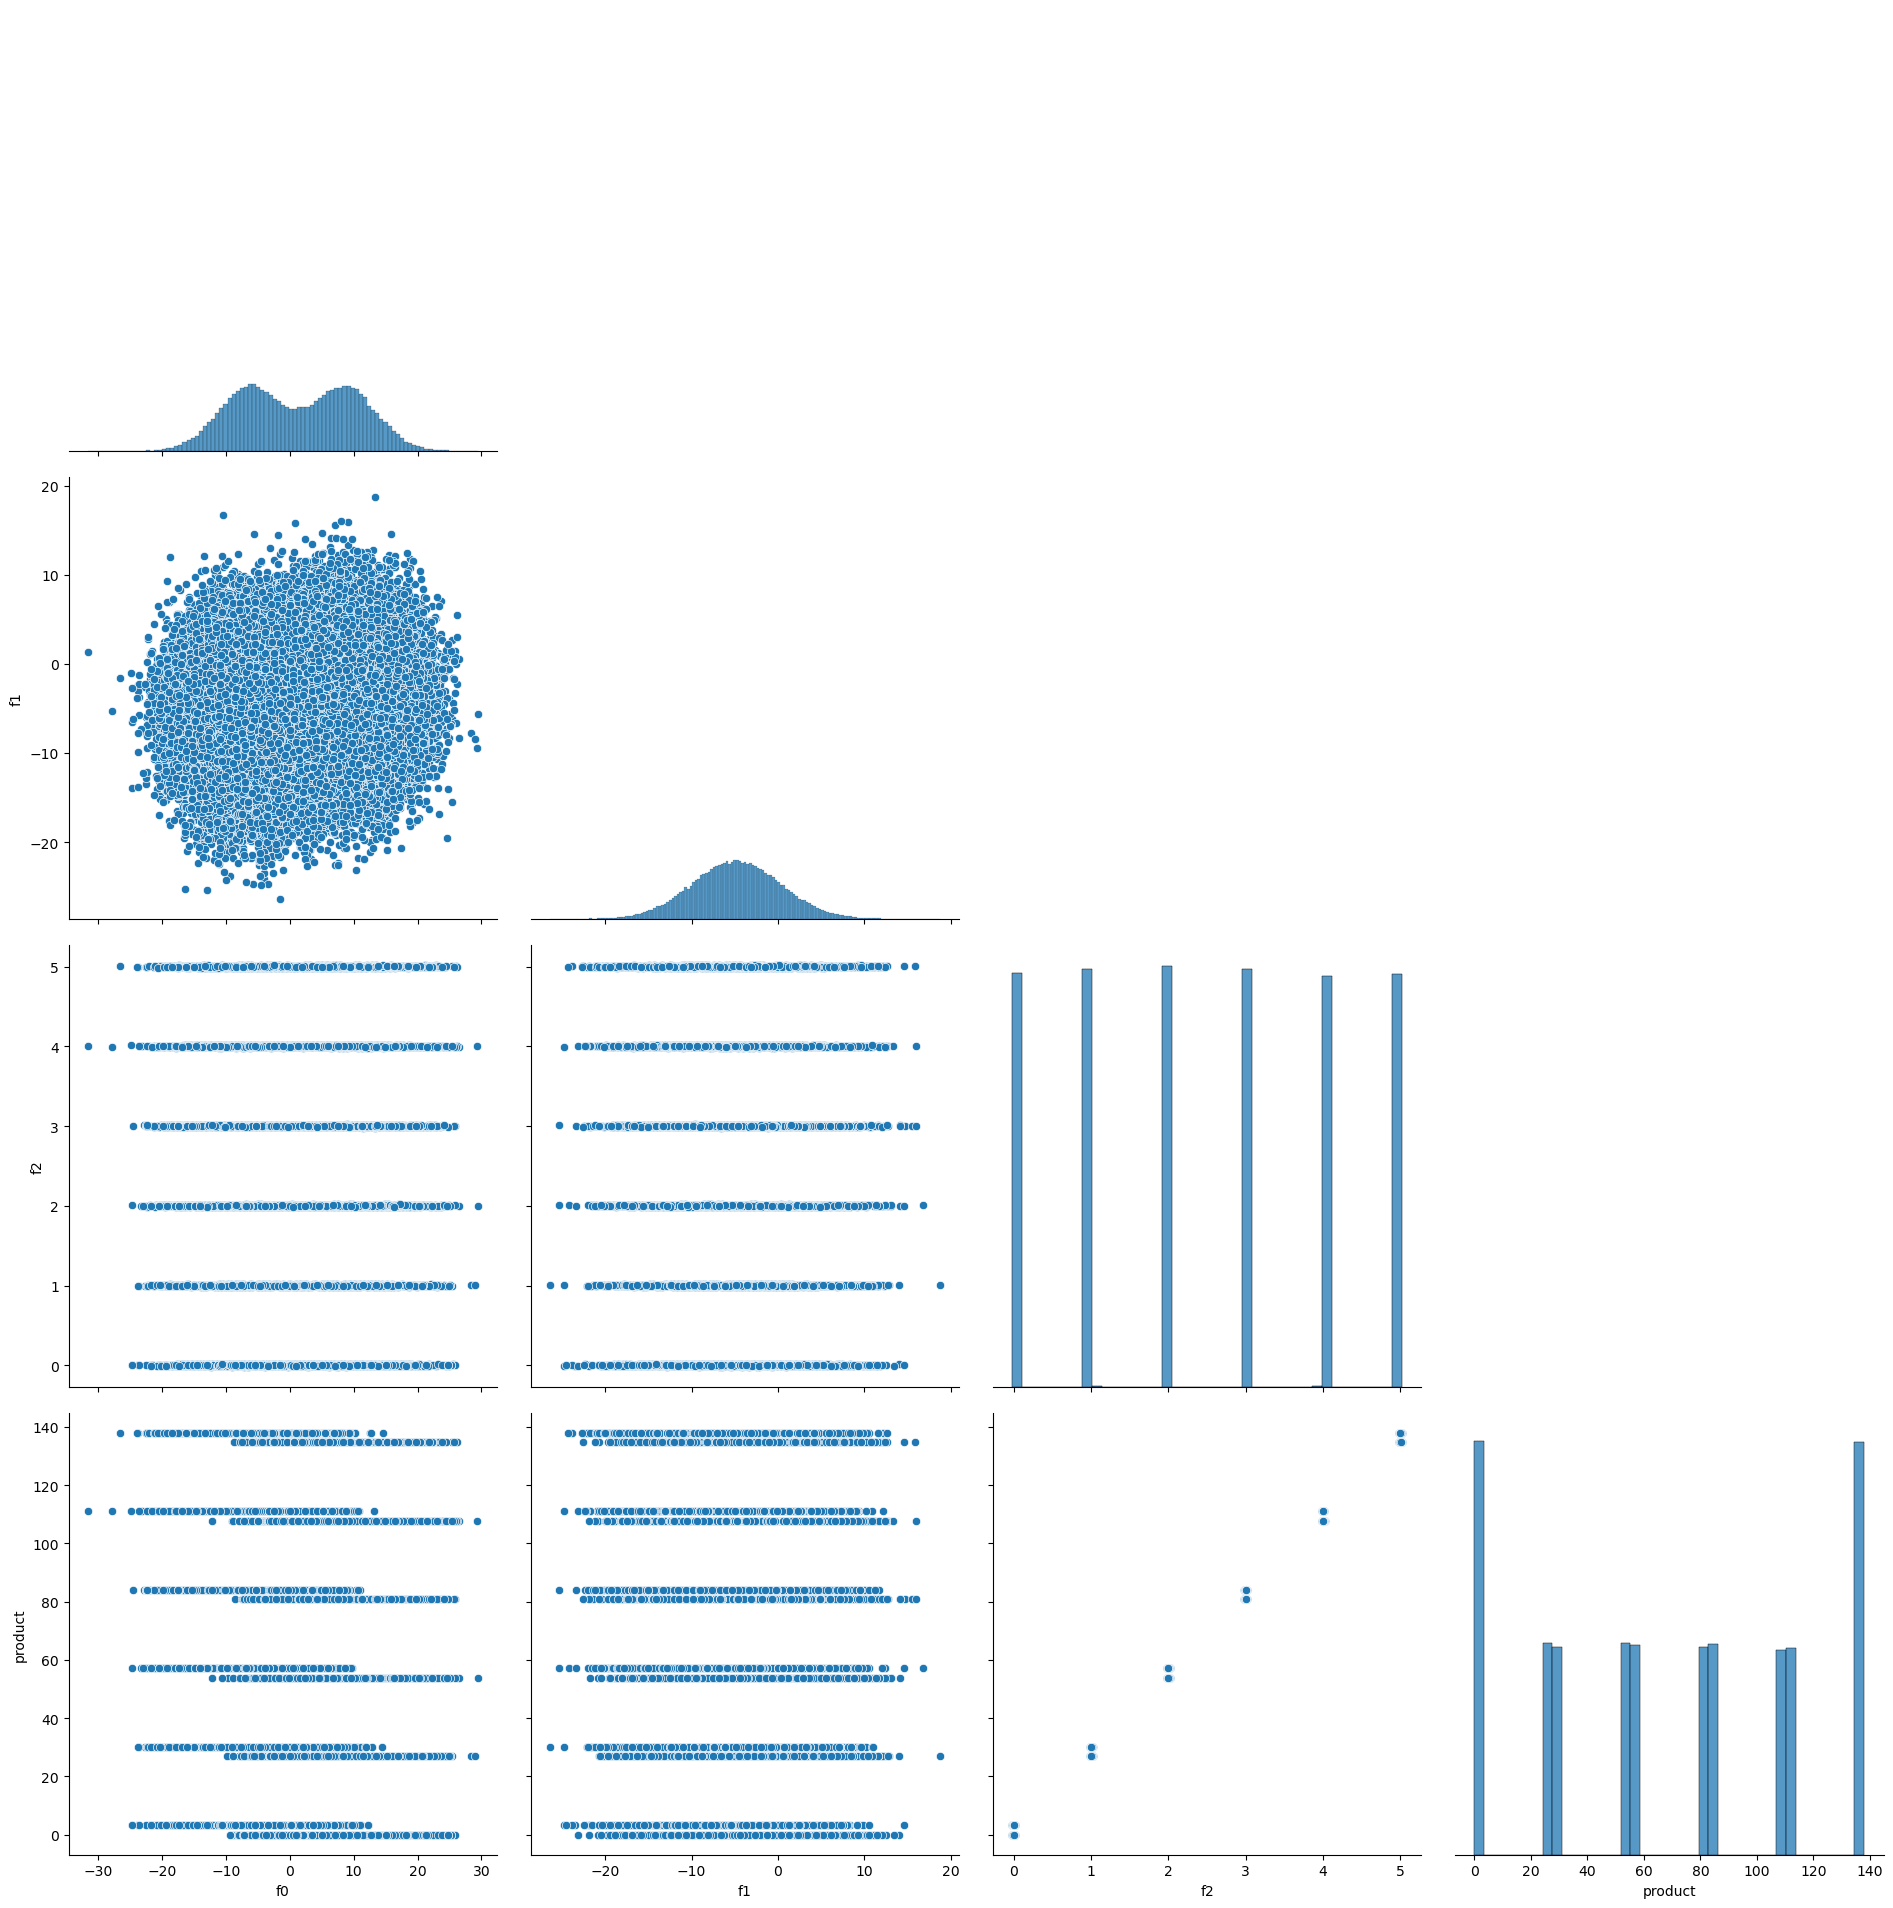

In [49]:
g = sns.pairplot(data_1, corner=True)
g.fig.set_size_inches(20, 20)

In [50]:
data_1.phik_matrix(interval_cols=cols_numeric)

,f0,f1,f2,product
f0,1.000000,0.196080,0.000000,0.628482
f1,0.196080,1.000000,0.000000,0.185965
f2,0.000000,0.000000,1.000000,0.978936
product,0.628482,0.185965,0.978936,1.000000


Выявлена сильная корреляция между показателем f2 и продукт. Думаю показатель f2 это глубина, что приводит к мысли, что на первом участке глубоко залегают залежи нефти, также это объясняет, почему на первом участке очень много мест без запасов. А также имеются участки с большими запасами нефти. Думаю на первом участке наибольшие запасы нефти, поэтому данные оставим как есть.

*Второй регион*

In [51]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732035,1.730408,3.473415,44.749722
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450439
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595024
max,7.238263,7.844801,16.739403,190.029831


In [52]:
zero_2 = data_2[data_2['product'] == 0]
zero_2

,f0,f1,f2,product
id,,,,
qeefd,-0.865596,-1.615247,-4.126441,0.0


Одна строка, данные оставляем.

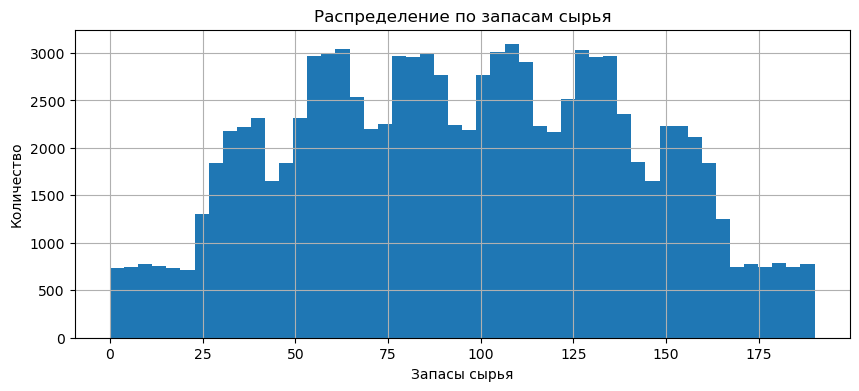

In [53]:
data_2['product'].hist(bins=50)
plt.title("Распределение по запасам сырья")
plt.xlabel('Запасы сырья')
plt.ylabel('Количество')
plt.show()

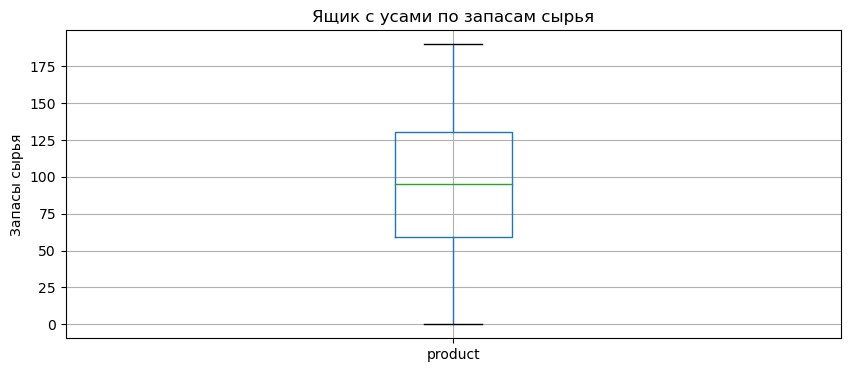

In [54]:
data_2.boxplot('product')
plt.title("Ящик с усами по запасам сырья")
plt.ylabel('Запасы сырья')
plt.show()

Во втором регионе запасы колеблятся от 59 до 130 тыс. барелей

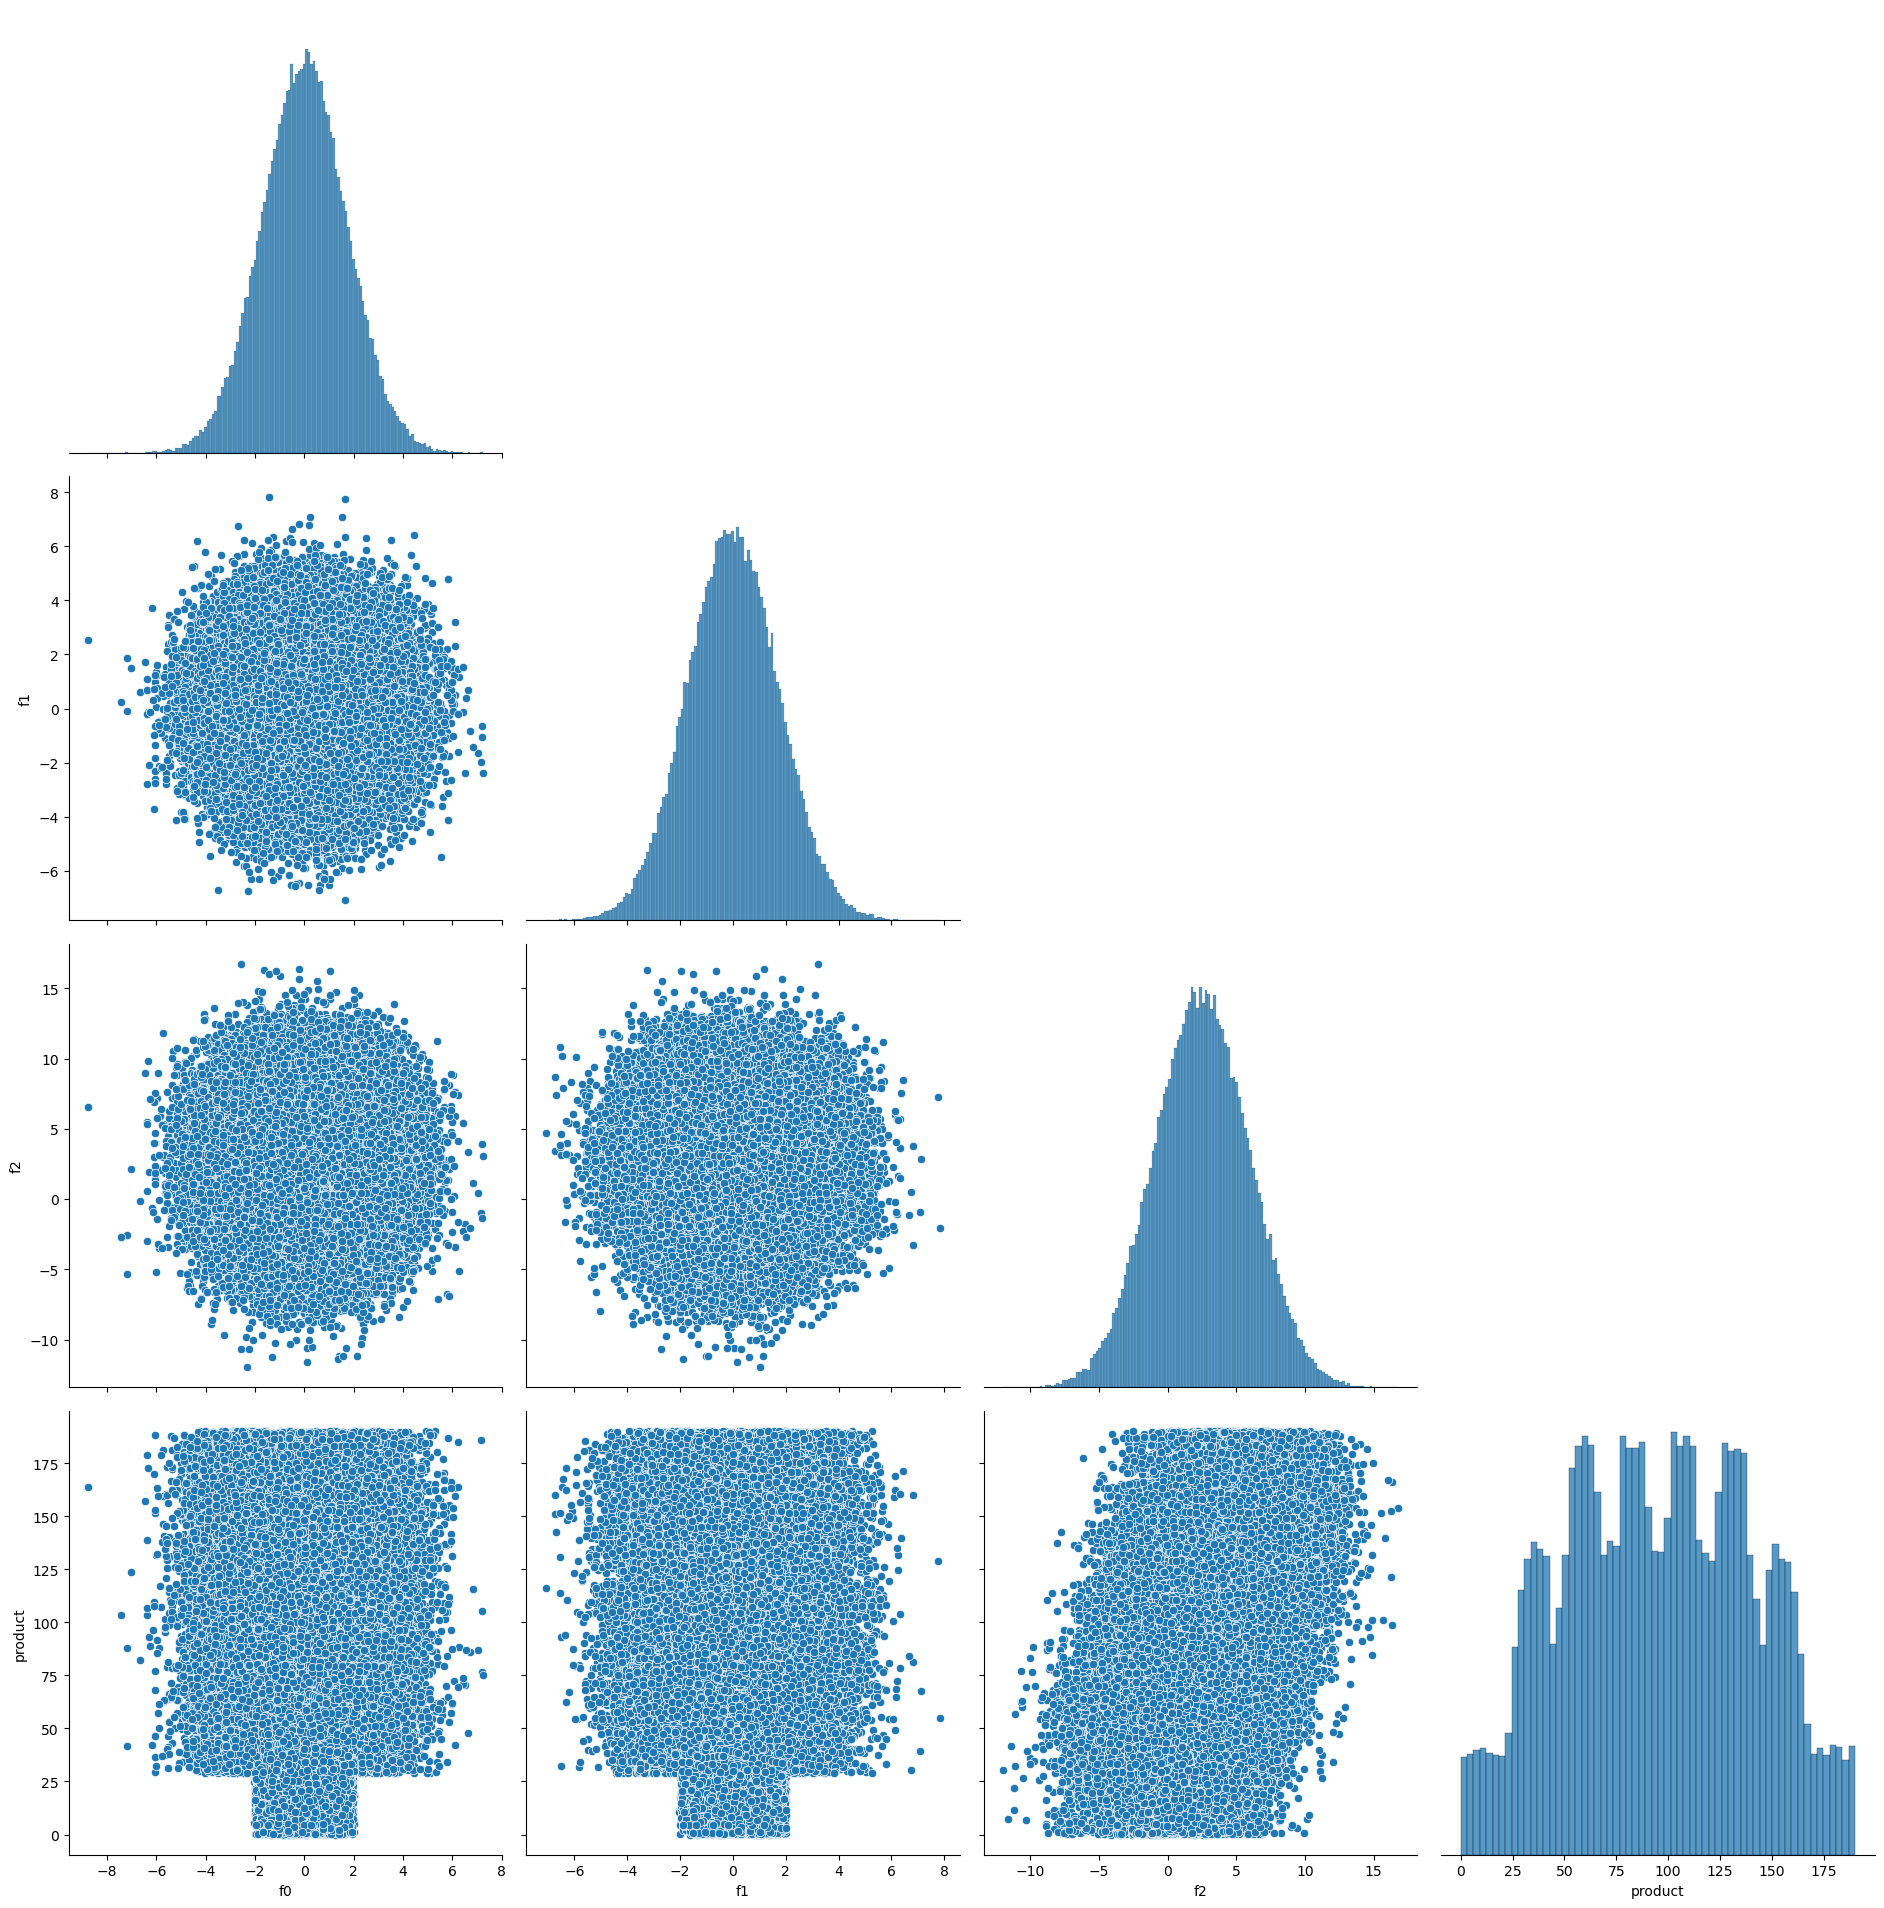

In [55]:
g = sns.pairplot(data_2, corner=True)
g.fig.set_size_inches(20, 20)

In [56]:
data_2.phik_matrix(interval_cols=cols_numeric)

,f0,f1,f2,product
f0,1.000000,0.000000,0.000000,0.201068
f1,0.000000,1.000000,0.000000,0.221022
f2,0.000000,0.000000,1.000000,0.443287
product,0.201068,0.221022,0.443287,1.000000


На втором участке нет линейной зависимости между объемами запасов и координатами скважин. Оставляем данные как есть.

Для наглядности построим общий график с распределением запасов по регионам.

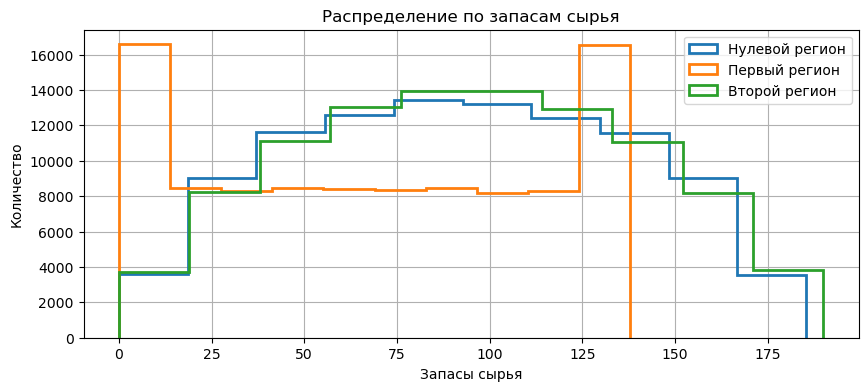

In [57]:
plt.title('Распределение по запасам сырья')
ax=data_0['product'].plot(kind='hist', grid=True, legend=True, histtype='step', linewidth=2, label='Нулевой регион')
ax1=data_1['product'].plot(kind='hist', grid=True, legend=True, histtype='step', linewidth=2, label='Первый регион', ax=ax)
ax2=data_2['product'].plot(kind='hist', grid=True, legend=True, histtype='step', linewidth=2, label='Второй регион', ax=ax1)
plt.xlabel('Запасы сырья')
plt.ylabel('Количество')
plt.show()

Нулевой и второй регион примерно совпадают по распределению объемов запасов. В то же время как первый регион имеет либо большой объем запаса, либо вообще нет нефти. 

**Вывод**

По загрузке и подготовке данных можно сделать следующие выводы:
1. По итогам предобработки данных могу сделать следующие выводы:
    - Пропуски в таблицах не обнаружены.
    - Столбец id переведен в индекс.
    - Заменен тип данных во всех столбцах  на формат float32.
    - Явные дубликаты в данных не выявлены.
2. По исследованию данных:
    - В нулевом регионе большинство скважин имеют запас сырья в пределах от 56 до 92 тыс. баррелей.
    - В первом регионе распределение очень интересно, разделилось примерно на 6 одинаковых частей. Запасы большинства скважин колеблется от 26 до 107 тыс. баррелей.
    - Во втором регионе запасы колеблятся от 59 до 130 тыс. баррелей.
    - Нулевой и второй регион примерно совпадают по распределению объемов запасов. В то же время как первый регион имеет либо большой объем запаса, либо вообще нет нефти.
    - Нулевой и второй регион примерно совпадают по распределению объемов запасов. В то же время как первый регион имеет либо большой объем запаса, либо вообще нет нефти.
    - В нулевом и втором регионе невыявлена сильная корреляция между координатами и запасом нефти. В первом регионе выявлена сильная корреляция между показателем f2 и продукт. Думаю показатель f2 это глубина, что приводит к мысли, что на первом участке глубоко залегают залежи нефти, также это объясняет, почему на первом участке очень много мест без запасов. А также имеются участки с большими запасами нефти. Думаю на первом участке наибольшие запасы нефти, поэтому данные оставим как есть.

## Шаг 2. Обучите и проверьте модель для каждого региона

**2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.**

*Нулевой регион*

Проведем разбивку данных на тренировочочную и валидационную выборки.

In [58]:
RANDOM_STATE = 42

X = data_0.drop(['product'], axis=1)
y = data_0['product']
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(
    X, 
    y, 
    test_size=0.25,
    random_state=RANDOM_STATE
)

In [59]:
X_train_0.shape, X_test_0.shape

((75000, 3), (25000, 3))

Выборка разделена на 2 части в сообношении 75:25.

*Первый регион*

Проведем те же манипуляции для первого региона.

In [60]:
X = data_1.drop(['product'], axis=1)
y = data_1['product']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X, 
    y, 
    test_size=0.25,
    random_state=RANDOM_STATE
)

In [61]:
X_train_1.shape, X_test_1.shape

((75000, 3), (25000, 3))

Выборка разделена.

*Второй регион*

Все то же самое для второго региона.

In [62]:
X = data_2.drop(['product'], axis=1)
y = data_2['product']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X, 
    y, 
    test_size=0.25,
    random_state=RANDOM_STATE
)

In [63]:
X_train_2.shape, X_test_2.shape

((75000, 3), (25000, 3))

Все данные разделены в соответствии с техническим заданием.

**2.2. Обучите модель и сделайте предсказания на валидационной выборке.**

*Нулевой регион*

In [64]:
model_0=make_pipeline(StandardScaler(), LinearRegression())
model_0.fit(X_train_0, y_train_0)
predict_0=model_0.predict(X_test_0)
rmse_0 = mean_squared_error(y_test_0, predict_0)**0.5
print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_0)
print('Коэффициент детерминации: %.2f' % r2_score(y_test_0, predict_0))

Среднеквадратичная ошибка RMSE: 37.76
Коэффициент детерминации: 0.27


*Первый регион*

In [65]:
model_1=make_pipeline(StandardScaler(), LinearRegression())
model_1.fit(X_train_1, y_train_1)
predict_1=model_1.predict(X_test_1)
rmse_1 = mean_squared_error(y_test_1, predict_1)**0.5
print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_1)
print('Коэффициент детерминации: %.2f' % r2_score(y_test_1, predict_1))

Среднеквадратичная ошибка RMSE: 0.89
Коэффициент детерминации: 1.00


*Второй регион*

In [66]:
model_2=make_pipeline(StandardScaler(), LinearRegression())
model_2.fit(X_train_2, y_train_2)
predict_2=model_2.predict(X_test_2)
rmse_2 = mean_squared_error(y_test_2, predict_2)**0.5
print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_2)
print('Коэффициент детерминации: %.2f' % r2_score(y_test_2, predict_2))

Среднеквадратичная ошибка RMSE: 40.15
Коэффициент детерминации: 0.20


**2.3. Сохраните предсказания и правильные ответы на валидационной выборке.**

*Нулевой регион*

In [67]:
print(f'Для нулевого региона:')
print(f'Средний запас фактического сырья = {y_test_0.mean():.2f} тыс. баррелей')
print(f'Средний запас предсказанного сырья = {predict_0.mean():.2f} тыс. баррелей')
print(f'Разница = {(1-y_test_0.mean()/predict_0.mean()):.2%}')
print(f'RMSE модели = {(mean_squared_error(y_test_0, predict_0)**0.5):.2f} тыс. баррелей')

Для нулевого региона:
Средний запас фактического сырья = 92.33 тыс. баррелей
Средний запас предсказанного сырья = 92.40 тыс. баррелей
Разница = 0.08%
RMSE модели = 37.76 тыс. баррелей


*Первый регион*

In [68]:
print(f'Для первого региона:')
print(f'Средний запас фактического сырья = {y_test_1.mean():.2f} тыс. баррелей')
print(f'Средний запас предсказанного сырья = {predict_1.mean():.2f} тыс. баррелей')
print(f'Разница = {(1-y_test_1.mean()/predict_1.mean()):.2%}')
print(f'RMSE модели = {(mean_squared_error(y_test_1, predict_1)**0.5):.2f} тыс. баррелей')

Для первого региона:
Средний запас фактического сырья = 68.73 тыс. баррелей
Средний запас предсказанного сырья = 68.71 тыс. баррелей
Разница = -0.02%
RMSE модели = 0.89 тыс. баррелей


*Второй регион*

In [69]:
print(f'Для второго региона:')
print(f'Средний запас фактического сырья = {y_test_2.mean():.2f} тыс. баррелей')
print(f'Средний запас предсказанного сырья = {predict_2.mean():.2f} тыс. баррелей')
print(f'Разница = {(1-y_test_2.mean()/predict_2.mean()):.2%}')
print(f'RMSE модели = {(mean_squared_error(y_test_2, predict_2)**0.5):.2f} тыс. баррелей')

Для второго региона:
Средний запас фактического сырья = 95.15 тыс. баррелей
Средний запас предсказанного сырья = 94.77 тыс. баррелей
Разница = -0.40%
RMSE модели = 40.15 тыс. баррелей


**2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.**

In [70]:
surya_stock = pd.DataFrame(index=['средний запас предсказанного сырья','RMSE модели'], columns=['0 регион','1 регион','2 регион'])
surya_stock['0 регион'] = predict_0.mean(), rmse_0
surya_stock['1 регион'] = predict_1.mean(), rmse_1
surya_stock['2 регион'] = predict_2.mean(), rmse_2
surya_stock

,0 регион,1 регион,2 регион
средний запас предсказанного сырья,92.398811,68.712875,94.771027
RMSE модели,37.756599,0.890280,40.145872


**2.5. Проанализируйте результаты.**

    В пункте обучение и проверка модели для каждого региона было проведено следующее:
    - Были разделены данные на обучающую и валидационную выборки в соотношении 72:25.
    - Расчитаны для каждого региона коэффициенты детерминации и средне-квадратичная ошибки.
    - Посчитан средний запас сырья и и средне-квадратичная ошибка для каждого рениона. Наиболее высокий запас сырья 94,77 предсказан во втором регионе, в то же время там наибольшая ошибка. Самая низкая ошибка в первом регионе, но наименьший запас предсказанного сырья 67,7 тыс. баррелей. Думаю это объясняется линейной зависимостью между целевыым показателем и показателем f2.

## Шаг 3. Подготовьтесь к расчёту прибыли

**3.1. Все ключевые значения для расчётов сохраните в отдельных переменны**

In [71]:
TOTAL_OBJECTS = 500 # количество исследуемых объектов, участвующих в обучении модели
BEST_OBJECT = 200 # количество лучших объектов в регионе, которые будут разработаны (из 500 оцененных)
BUDGET = 10_000_000_000 # бюджет проекта для одного региона
PROFITABILITY= 45_0000 # доходность одной единицы продукта (= 450 за баррель * 1000 баррелей в одной единице объекта "total")
PROBABILITY_OF_LOSS = 0.025 # максимально допустимая веросятность убытков

**3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.**

In [72]:
break_event_point = (BUDGET / PROFITABILITY) / BEST_OBJECT
print(f'Точка безубыточности проекта равна добыче {break_event_point:.2f} баррелей в одной из {BEST_OBJECT} скважин одного региона.')

Точка безубыточности проекта равна добыче 111.11 баррелей в одной из 200 скважин одного региона.


Сравним средний запас нефти в кажом регионе с точкой безубыточности.

In [73]:
print(f'Разница между средним объемом нефти в нулевом регионе с точкой безубыточности:%.2f тыс.баррелей'%(data_0['product'].mean() - break_event_point))
print(f'Разница между средним объемом нефти в первом регионе с точкой безубыточности:%.2f тыс.баррелей'%(data_1['product'].mean() - break_event_point))
print(f'Разница между средним объемом нефти во втором регионе с точкой безубыточности:%.2f тыс.баррелей'%(data_2['product'].mean() - break_event_point))

Разница между средним объемом нефти в нулевом регионе с точкой безубыточности:-18.61 тыс.баррелей
Разница между средним объемом нефти в первом регионе с точкой безубыточности:-42.29 тыс.баррелей
Разница между средним объемом нефти во втором регионе с точкой безубыточности:-16.11 тыс.баррелей


**3.3. Напишите выводы по этапу подготовки расчёта прибыли**

    При подготовке расчета прибыли было проведено следующее:
    - Созданы ключевые константы.
    - Рассчитана точка безубыточности для разработки новой скважины.
    - Точка безубыточности проекта равна добыче 111.11 баррелей в одной из 200 скважин одного региона.
    - Разница между средним объемом нефти в нулевом регионе с точкой безубыточности:-18.61 тыс.баррелей
    - Разница между средним объемом нефти в первом регионе с точкой безубыточности:-42.29 тыс.баррелей
    - Разница между средним объемом нефти во втором регионе с точкой безубыточности:-16.11 тыс.баррелей
    - По моему предположению второй регион наиболее близок к точке безубыточности. Но так как мы будем выбирать всего 200 скважин с максимальными показателями, то ситуация может сильно измениться.

## Шаг 4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

**4.1. Выберите скважины с максимальными значениями предсказаний.**

*Нулевой регион*

Теперь выберем топ 200 скважин с наилучшими предсказаниями.

In [74]:
X_test_0_new = X_test_0.join(y_test_0)

In [75]:
X_test_0_new['predict'] = model_0.predict(X_test_0)

In [76]:
df_200_0 = X_test_0_new.sort_values(
    by='predict', 
    ascending=False
).head(BEST_OBJECT)

In [77]:
X_test_0_new = X_test_0_new.drop(['f0', 'f1', 'f2'], axis=1)

Создадим столбец с прибылью/убытком каждой скважины.

In [78]:
df_200_0

,f0,f1,f2,product,predict
id,,,,,
lfgbR,1.853784,-0.153503,13.585450,153.639832,176.536102
WcCwe,1.723956,-0.376442,13.139065,140.631653,176.274506
he3xS,0.370519,-0.283066,13.668868,178.879517,173.249512
kU92A,0.896968,-0.498996,12.828117,176.807831,172.802704
2I3WV,1.114191,-0.217015,13.302975,130.985687,172.744995
...,...,...,...,...,...
FbmoM,0.647452,-0.710161,8.595942,132.951874,146.952667
LagHO,0.724481,-0.555652,8.884751,136.027695,146.948776
hbgto,0.324662,-0.339168,9.585144,162.142532,146.947495


В нулевом регионе топ 200 скважин имеют предсказания от 176 до 146 тыс. баррелей, что подходит под критерий больше 111,11 тыс. бареллей

*Первый регион*

Проведем все те же манипуляции, что были для нулевого региона.

In [79]:
X_test_1_new = X_test_1.join(y_test_1)

In [80]:
X_test_1_new['predict'] = model_1.predict(X_test_1)

In [81]:
df_200_1 = X_test_1_new.sort_values(
    by='predict', 
    ascending=False
).head(BEST_OBJECT)

In [82]:
X_test_1_new = X_test_1_new.drop(['f0', 'f1', 'f2'], axis=1)

Проведем расчет прибыли каждой скважины в 1 регионе.

In [83]:
df_200_1

,f0,f1,f2,product,predict
id,,,,,
kpPCd,-23.884180,-3.773158,5.001008,137.945404,139.983276
vd9ik,-20.401676,-11.205156,5.003275,137.945404,139.700806
a8qSM,-17.391680,-12.347464,5.015414,137.945404,139.616547
1m8tG,-19.352200,-7.969103,5.004618,137.945404,139.514771
55xmk,-19.963551,-3.719157,5.003169,137.945404,139.472229
...,...,...,...,...,...
DcaCI,-13.318420,-0.251984,5.002955,137.945404,138.428345
WgS7g,-12.617043,-6.058674,5.002026,137.945404,138.427521
q7d4S,-10.788478,-11.757641,5.007237,137.945404,138.426483


В первом регионе разделение по предсказанию запаса нефти в топ 200 скважин примерно одинаково, и имеют разброс от 140 до 138 тыс. баррелей. Что подходит под точку безубыточности 111,11 тыс. баррелей со скважины.

*Второй регион*

Найдем топ 200 скважин по предсказанному запасу нефти во втором регионе.

In [84]:
X_test_2_new = X_test_2.join(y_test_2)

In [85]:
X_test_2_new['predict'] = model_2.predict(X_test_2)

In [86]:
df_200_2 = X_test_2_new.sort_values(
    by='predict', 
    ascending=False
).head(BEST_OBJECT)

In [87]:
X_test_2_new = X_test_2_new.drop(['f0', 'f1', 'f2'], axis=1)

In [88]:
df_200_2

,f0,f1,f2,product,predict
id,,,,,
rtPef,-0.214989,1.849141,15.648690,101.225037,170.529251
KJ6bS,0.517061,-2.686813,15.498363,151.655777,169.673370
Jz7Ou,1.275966,-2.877779,14.748519,92.947334,165.300766
yJO5k,-0.005191,-1.141924,14.614990,97.775978,164.613937
bxRO7,-0.800689,-0.417209,14.492272,122.460899,163.964035
...,...,...,...,...,...
S6g0H,-2.151721,0.669393,10.761671,179.654572,142.609528
kLkT4,0.587732,-0.539400,10.790408,142.101685,142.562912
hFHZS,0.233815,-0.030618,10.772275,121.983864,142.480560


Во втором регионе предсказание объемов запасов нефти имеет разброс от 170 до 142 тыс. баррелей. Что тоже соответсвует точке безубыточности 111,11 тыс. баррелей.

**4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.**

*Нулевой регион*

Посчитаем объем предсказанного сырья в нулевом регионе.

In [89]:
extraction_0 = df_200_0['predict'].sum()
print(f'Суммарный запас сырья в {BEST_OBJECT} лучших скважинах нулевого региона составит: %.2f тыс.баррелей'%extraction_0)

Суммарный запас сырья в 200 лучших скважинах нулевого региона составит: 30881.46 тыс.баррелей


*Первый регион*

Посчитаем предсказанный объем сырья в первом регионе.

In [90]:
extraction_1 = df_200_1['predict'].sum()
print(f'Суммарный запас сырья в {BEST_OBJECT} лучших скважинах первого региона составит: %.2f тыс.баррелей'%extraction_1)

Суммарный запас сырья в 200 лучших скважинах первого региона составит: 27748.75 тыс.баррелей


*Второй регион*

Посчитаем предсказанный объем сырья во втором регионе.

In [91]:
extraction_2 = df_200_2['predict'].sum()
print(f'Суммарный запас сырья в {BEST_OBJECT} лучших скважинах второго региона составит: %.2f тыс.баррелей'%extraction_2)

Суммарный запас сырья в 200 лучших скважинах второго региона составит: 29728.85 тыс.баррелей


Наилучший результат предсказан в нулевом регионе, прогнозируемый объем в ТОП-200 скважин составит 32669,46 тыс. баррелей.

**4.3. Рассчитайте прибыль для полученного объёма сырья.**

Расчитаем прибыль от прогнозируемого объема сырья.

*Нулевой регион*

In [92]:
profit_pred_0=(extraction_0*PROFITABILITY)-BUDGET
print('Прибыль для полученного объёма сырья нулевого региона составит %.2f рублей'%profit_pred_0)

Прибыль для полученного объёма сырья нулевого региона составит 3896659179.69 рублей


*Первый регион*

In [93]:
profit_pred_1=(extraction_1*PROFITABILITY)-BUDGET
print('Прибыль для полученного объёма сырья нулевого региона составит %.2f рублей'%profit_pred_1)

Прибыль для полученного объёма сырья нулевого региона составит 2486939257.81 рублей


*Второй регион*

In [94]:
profit_pred_2=(extraction_2*PROFITABILITY)-BUDGET
print('Прибыль для полученного объёма сырья нулевого региона составит %.2f рублей'%profit_pred_2)

Прибыль для полученного объёма сырья нулевого региона составит 3377984082.03 рублей


Наибольшую прибыль прогнозируется получать с нулевого региона 4,7 млрд. руб, на втором месте второй регион с прогнозируемой прибылью 4 млрд. руб. и замыкает второй регион с прогнозируемой прибылью 2,5 млрд. руб.

## Шаг 5. Посчитайте риски и прибыль для каждого региона

**5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.**

In [95]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.reset_index(drop=True).sort_values(ascending=False)[:count]
    selected = target[probs_sorted.index]
    return selected.sum() * PROFITABILITY - BUDGET

**5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.**

In [96]:
state = np.random.RandomState(12345)
values = []
for _ in range(1000):
    subsample = X_test_0_new['product'].sample(TOTAL_OBJECTS, replace=True, random_state=state)
    probs_subsample = X_test_0_new['predict'][subsample.index]
    values.append(revenue(subsample, probs_subsample, BEST_OBJECT))

values = pd.Series(values)

mean = values.mean() / 10e5
print(f'Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = {mean:.0f} млн. рублей.')
lower = values.quantile(0.025)/10e5
upper = values.quantile(0.975)/10e5
risk = values.apply(lambda x: x < 0).sum() / len(values)

print(f'Нижний квантиль: %.2f млн. руб.'%lower)
print(f'Верхний квантиль: %.2f, млн. руб'%upper)
print(f'Риск убытков составляет = {risk:.2%}')

Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = 406 млн. рублей.
Нижний квантиль: -117.74 млн. руб.
Верхний квантиль: 911.74, млн. руб
Риск убытков составляет = 6.70%


In [97]:
values = []
for _ in range(1000):
    subsample = X_test_1_new['product'].sample(TOTAL_OBJECTS, replace=True, random_state=state)
    probs_subsample = X_test_1_new['predict'][subsample.index]
    values.append(revenue(subsample, probs_subsample, BEST_OBJECT))

values = pd.Series(values)

mean = values.mean() / 10e5
print(f'Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = {mean:.0f} млн. рублей.')
lower = values.quantile(0.025)/10e5
upper = values.quantile(0.975)/10e5
risk = values.apply(lambda x: x < 0).sum() / len(values)

print(f'Нижний квантиль: %.2f млн. руб.'%lower)
print(f'Верхний квантиль: %.2f, млн. руб'%upper)
print(f'Риск убытков составляет = {risk:.2%}')

Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = 442 млн. рублей.
Нижний квантиль: 35.73 млн. руб.
Верхний квантиль: 828.01, млн. руб
Риск убытков составляет = 1.60%


In [98]:
values = []
for _ in range(1000):
    subsample = X_test_2_new['product'].sample(TOTAL_OBJECTS, replace=True, random_state=state)
    probs_subsample = X_test_2_new['predict'][subsample.index]
    values.append(revenue(subsample, probs_subsample, BEST_OBJECT))

values = pd.Series(values)

mean = values.mean() / 10e5
print(f'Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = {mean:.0f} млн. рублей.')
lower = values.quantile(0.025)/10e5
upper = values.quantile(0.975)/10e5
risk = values.apply(lambda x: x < 0).sum() / len(values)

print(f'Нижний квантиль: %.2f млн. руб.'%lower)
print(f'Верхний квантиль: %.2f, млн. руб'%upper)
print(f'Риск убытков составляет = {risk:.2%}')

Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = 385 млн. рублей.
Нижний квантиль: -164.79 млн. руб.
Верхний квантиль: 888.21, млн. руб
Риск убытков составляет = 7.80%


**5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.**

Наилучшим регионом для разработки является первый регион. Как изначально предполагалось, в этом регионе сильная корреляция между показателем f2 и объемом запасов нефти. Риск убытков в первом регионе составляет 1,6 %, это ниже 2,5 % установленным заказчиком. Средняя валовая прибыль с 200 лучших скважин в первом регионе отобранных по предсказанию составляет 442 млн. рублей.,Риск убытков нулевого и второго региона ниже установленных заказчиком и составляет в нулевом регионе 6,7 % и во втором регионе 7,8 % соответственно. 

## Шаг 6. Общий вывод.

1. По загрузке и подготовке данных можно сделать следующие выводы:
    1. По итогам предобработки данных могу сделать следующие выводы:
        - Пропуски в таблицах не обнаружены.
        - Столбец id переведен в индекс.
        - Заменен тип данных во всех столбцах  на формат float32.
        - Явные дубликаты в данных не выявлены.
    2. По исследованию данных:
        - В нулевом регионе большинство скважин имеют запас сырья в пределах от 56 до 92 тыс. баррелей.
        - В первом регионе распределение очень интересно, разделилось примерно на 6 одинаковых частей. Запасы большинства скважин колеблется от 26 до 107 тыс. баррелей.
        - Во втором регионе запасы колеблятся от 59 до 130 тыс. баррелей.
        - Нулевой и второй регион примерно совпадают по распределению объемов запасов. В то же время как первый регион имеет либо большой объем запаса, либо вообще нет нефти.
        - Нулевой и второй регион примерно совпадают по распределению объемов запасов. В то же время как первый регион имеет либо большой объем запаса, либо вообще нет нефти.
        - В нулевом и втором регионе невыявлена сильная корреляция между координатами и запасом нефти. В первом регионе выявлена сильная корреляция между показателем f2 и продукт. Думаю показатель f2 это глубина, что приводит к мысли, что на первом участке глубоко залегают залежи нефти, также это объясняет, почему на первом участке очень много мест без запасов. А также имеются участки с большими запасами нефти. Думаю на первом участке наибольшие запасы нефти, поэтому данные оставим как есть.
2. В пункте обучение и проверка модели для каждого региона было проведено следующее:
    - Были разделены данные на обучающую и валидационную выборки в соотношении 72:25.
    - Расчитаны для каждого региона коэффициенты детерминации и средне-квадратичная ошибки.
    - Посчитан средний запас сырья и и средне-квадратичная ошибка для каждого рениона. Наиболее высокий запас сырья 94,77 предсказан во втором регионе, в то же время там наибольшая ошибка. Самая низкая ошибка в первом регионе, но наименьший запас предсказанного сырья 67,7 тыс. баррелей. Думаю это объясняется линейной зависимостью между целевыым показателем и показателем f2.
3. При подготовке расчета прибыли было проведено следующее:
    - Созданы ключевые константы.
    - Рассчитана точка безубыточности для разработки новой скважины.
    - Точка безубыточности проекта равна добыче 111.11 баррелей в одной из 200 скважин одного региона.
    - Разница между средним объемом нефти в нулевом регионе с точкой безубыточности:-18.61 тыс.баррелей
    - Разница между средним объемом нефти в первом регионе с точкой безубыточности:-42.29 тыс.баррелей
    - Разница между средним объемом нефти во втором регионе с точкой безубыточности:-16.11 тыс.баррелей
    - По моему предположению второй регион наиболее близок к точке безубыточности. Но так как мы будем выбирать всего 200 скважин с максимальными показателями, то ситуация может сильно измениться.
4. Наибольшую прибыль прогнозируется получать с нулевого региона 4,7 млрд. руб, на втором месте второй регион с прогнозируемой прибылью 4 млрд. руб. и замыкает второй регион с прогнозируемой прибылью 2,5 млрд. руб.
5. Наилучшим регионом для разработки является первый регион. Как изначально предполагалось, в этом регионе сильная корреляция между показателем f2 и объемом запасов нефти. Риск убытков в первом регионе составляет 1,6 %, это ниже 2,5 % установленным заказчиком. Средняя валовая прибыль с 200 лучших скважин в первом регионе отобранных по предсказанию составляет 442 млн. рублей.,Риск убытков нулевого и второго региона ниже установленных заказчиком и составляет в нулевом регионе 6,7 % и во втором регионе 7,8 % соответственно. 